# Randomized Kaczmarz algorithm with conjugate symmetry --- Parallel solver

In [1]:
import os, math, time, copy
import numpy as np
import numpy.matlib
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import h5py
plt.style.use('default')
import multiprocessing

from harmonic_helper import *

In [2]:
fname = "3D_face_k_60.mat"

v, D_mat = HarmIO.read_hdf5(fname)
D = D_mat.T
V = v.T

_m, _n = D.shape
print("System size is {} rows and {} columns for {} degrees".format(_m, _n, int(np.sqrt(_n)-1)))

System size is 21238 rows and 3844 columns for 61 degrees



Solver's time: 1.2766780455907185 min


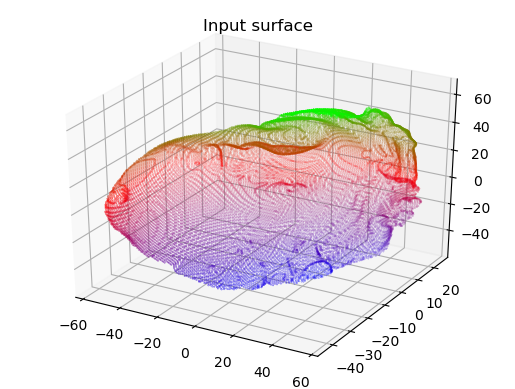

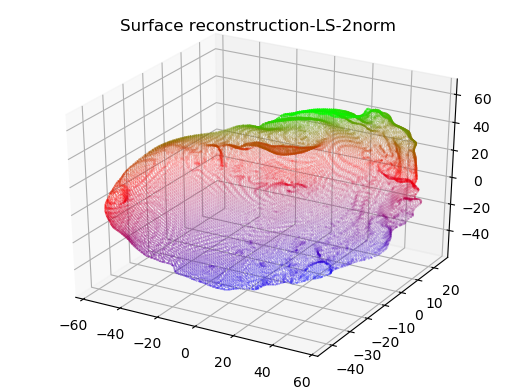

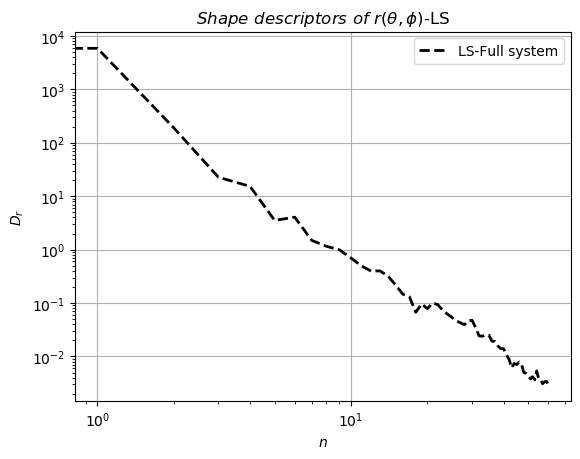

In [3]:
# The fastest parallel Least-squares solver (uses all the cores!)
coefs_LS = L2Solvers.solve_2_norm(D, V)

ax = plt.axes(projection='3d')
ax.scatter3D(V[:, 1], V[:, 2], V[:, 0], c=V[:, 0], s=0.1, cmap='brg');
plt.title("Input surface")
plt.show()

V1 = np.real(D @ coefs_LS)
ax = plt.axes(projection='3d')
ax.scatter3D(V1[:, 1], V1[:, 2], V1[:, 0], c=V1[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-LS-2norm")
plt.show()

Dx_LS, Dy_LS, Dz_LS = shape_descriptors(coefs_LS)
Dr_LS = Dx_LS + Dy_LS + Dz_LS
plt.figure()
plt.loglog(np.arange(len(Dr_LS)), Dr_LS, '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [4]:
max_iter = 4
relax = 0.3

x_RK_solver = Kaczmarz_solver(D, V[:, 0], x0=[], iterations = max_iter, relaxation = relax)
y_RK_solver = Kaczmarz_solver(D, V[:, 1], x0=[], iterations = max_iter, relaxation = relax)
z_RK_solver = Kaczmarz_solver(D, V[:, 2], x0=[], iterations = max_iter, relaxation = relax)

t1 = time.time()
manager = multiprocessing.Manager()
return_dict = manager.dict()

jobs = []
process1 = multiprocessing.Process(target=x_RK_solver.solve_Kaczmarz_conjugate_sym_parallel, 
                                args=("coef_x_kz", "history_x",  return_dict))
process2 = multiprocessing.Process(target=y_RK_solver.solve_Kaczmarz_conjugate_sym_parallel, 
                                args=("coef_y_kz", "history_y", return_dict))
process3 = multiprocessing.Process(target=z_RK_solver.solve_Kaczmarz_conjugate_sym_parallel, 
                                args=("coef_z_kz", "history_z", return_dict))
jobs.append(process1)
jobs.append(process2)
jobs.append(process3)

process1.start()
process2.start()
process3.start()

process1.join()
process2.join()
process3.join()

coef_x_kz = copy.copy(return_dict['coef_x_kz'])
coef_y_kz = copy.copy(return_dict['coef_y_kz'])
coef_z_kz = copy.copy(return_dict['coef_z_kz'])

hist_coef_x_kz = copy.copy(return_dict['history_x'])
hist_coef_y_kz = copy.copy(return_dict['history_y'])
hist_coef_z_kz = copy.copy(return_dict['history_z'])

coefs_RK = np.array([coef_x_kz, coef_y_kz, coef_z_kz]).T

print("Overall parallel processing time is {} min".format((time.time()-t1)/60))


Solver's time: 4.9161577224731445 sec

Solver's time: 4.99406361579895 sec

Solver's time: 5.382256031036377 sec
Overall parallel processing time is 0.7205824136734009 min


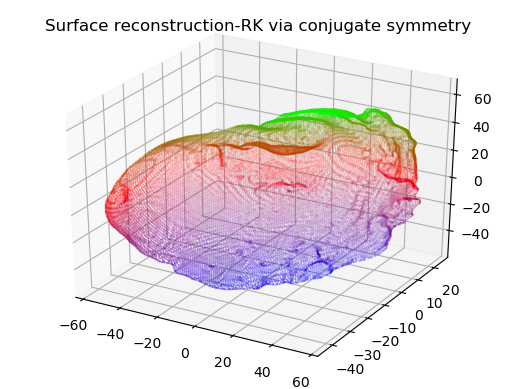

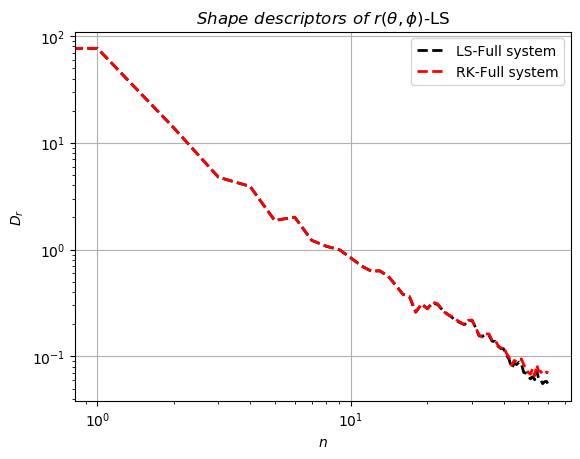

In [5]:
V2 = np.real(D @ coefs_RK)
ax = plt.axes(projection='3d')
ax.scatter3D(V2[:, 1], V2[:, 2], V2[:, 0], c=V2[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via conjugate symmetry")
plt.show()

Dx_RK, Dy_RK, Dz_RK = shape_descriptors(coefs_RK)
Dr_RK = Dx_RK + Dy_RK + Dz_RK

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=2, markersize=10, label='RK-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

Overall parallel processing time is 1.7671913703282673 min


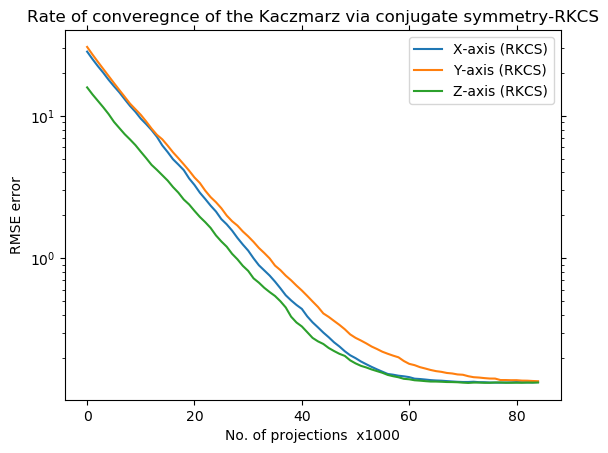

In [6]:
rec_steps = 1000

# A work around pipline comunications between processors (not an optimal solution)
x_RK_solver.history_switch = True
y_RK_solver.history_switch = True
z_RK_solver.history_switch = True
x_RK_solver.sym_switch =  True
y_RK_solver.sym_switch =  True
z_RK_solver.sym_switch =  True
x_RK_solver.solutions_history = hist_coef_x_kz
y_RK_solver.solutions_history = hist_coef_y_kz
z_RK_solver.solutions_history = hist_coef_z_kz

t1 = time.time()
manager2 = multiprocessing.Manager()
return_dict2 = manager2.dict()

jobs = []
process1 = multiprocessing.Process(target=x_RK_solver.reconstruct_history_parallel, 
                                args=(rec_steps, "rec_error_x", return_dict2))
process2 = multiprocessing.Process(target=y_RK_solver.reconstruct_history_parallel, 
                                args=(rec_steps, "rec_error_y", return_dict2))
process3 = multiprocessing.Process(target=z_RK_solver.reconstruct_history_parallel, 
                                args=(rec_steps, "rec_error_z", return_dict2))
jobs.append(process1)
jobs.append(process2)
jobs.append(process3)

process1.start()
process2.start()
process3.start()

process1.join()
process2.join()
process3.join()

rec_error_x = copy.copy(return_dict2['rec_error_x'])
rec_error_y = copy.copy(return_dict2['rec_error_y'])
rec_error_z = copy.copy(return_dict2['rec_error_z'])
print("Overall parallel processing time is {} min".format((time.time()-t1)/60))

f = plt.figure()
ax = f.add_subplot(111)
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")
plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
#plt.grid()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();